# Tensorflow Network 4

## I will be using the same models from Network 3, but will be training them on a different dataset

- By updated dataset, the dataset is now restricted only to the starting inning and matches with >= 120 balls

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
current_dir = Path.cwd()
parent_dir = current_dir.parent.parent
from sklearn.preprocessing import MinMaxScaler
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
player_scaler = MinMaxScaler()

from tensorflow.keras.regularizers import l2

#### Getting the data

In [127]:
dev_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"dev_data.pkl")
test_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"test_data.pkl")
training_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"training_data.pkl")
dev_data.columns.get_level_values(0).unique()

Index(['Player Status', 'Inning Data', 'Batting Stats', 'Bowling Stats',
       'Ground Data', 'Final Output'],
      dtype='object')

In [128]:
training_x_players = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"train_x_players.pkl")
dev_x_players = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"dev_x_players.pkl")

In [129]:
ground_player_lineup = pd.read_pickle(parent_dir / "Resources/ground_player_lineup.pkl")
batting_teams = ground_player_lineup['Details']['Batting Team']

In [130]:
def return_bat_only(group):
    try:
        match_index = group.name
    except:
        match_index = 1359787
    batting_country = batting_teams[match_index]
    return group.loc[match_index, batting_country]

### Important Cell: In the following cells I am only selecting the batting team

In [131]:
dev_data = dev_data.groupby(level = [0]).apply(return_bat_only)
test_data = test_data.groupby(level = [0]).apply(return_bat_only)
training_data = training_data.groupby(level = [0]).apply(return_bat_only)
dev_data

Player Status                                                \
                   Batting Team                                                 
                             P1   P2   P3   P4   P5   P6   P7   P8    P9  P10   
        Over Ball                                                               
249227  0    0             10.0  5.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  1.0   
             1             10.0  5.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  1.0   
             2             10.0  5.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  1.0   
             3             10.0  5.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  1.0   
             4             10.0  5.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  1.0   
...                         ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   
1380587 19   1              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  10.0  5.0   
             2              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  10.0  5.0   
             3              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  5.0   
             4              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  5.0   
             5              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   

                   ...                               Ground Data  \
                   ...                                         -   
                   ... Zahur Ahmed Chowdhury Stadium, Chattogram   
        Over Ball  ...                                             
249227  0    0     ...                                       0.0   
             1     ...                                       0.0   
             2     ...                                       0.0   
             3     ...                                       0.0   
             4     ...                                       0.0   
...                ...                                       ...   
1380587 19   1     ...                                       0.0   
             2     ...                                       0.0   
             3     ...                                       0.0   
             4     ...                                       0.0   
             5     ...                                       0.0   

                                                \
                                                 
                  St Albans Club, Buenos Aires   
        Over Ball                                
249227  0    0                             0.0   
             1                             0.0   
             2                             0.0   
             3                             0.0   
             4                             0.0   
...                                        ...   
1380587 19   1                             0.0   
             2                             0.0   
             3                             0.0   
             4                             0.0   
             5                             0.0   

                                                               \
                                                                
                  Belgrano Athletic Club Ground, Buenos Aires   
        Over Ball                                               
249227  0    0                                            0.0   
             1                                            0.0   
             2                                            0.0   
             3                                            0.0   
             4                                            0.0   
...                                                       ...   
1380587 19   1                                            0.0   
             2                                            0.0   
             3                                            0.0   
             4                                            0.0   
             5                                            0.0   

                                                      

In [7]:
training_x_players = training_x_players.groupby(level = [0]).apply(return_bat_only)
dev_x_players = dev_x_players.groupby(level = [0]).apply(return_bat_only)

### Showing Data shapes

In [8]:
training_x_inning = training_data['Inning Data'].loc[:, [ ('Inning Data','Total Runs'), ('Inning Data','Out')]]
training_x_ground = training_data['Ground Data']
training_y = training_data['Final Output']

dev_data_x = dev_data['Inning Data'].loc[:, [('Inning Data','Total Runs'), ('Inning Data','Out')]]
dev_x_ground = dev_data['Ground Data']
dev_data_y = dev_data['Final Output']

output_scaler.fit(training_y.to_numpy(dtype = 'float32'))
input_scaler.fit(training_x_inning.to_numpy(dtype = 'float32'))
player_scaler.fit(training_x_players.to_numpy(dtype = 'float32'))

print(training_x_inning.shape)
print(training_x_ground.shape)
print(training_y.shape)
print()
print(dev_data_x.shape)
print(dev_x_ground.shape)
print(dev_data_y.shape)

(134195, 2)
(134195, 245)
(134195, 1)

(12404, 2)
(12404, 245)
(12404, 1)


### Padding

In [13]:
## Using masking and padding to make all the data properly input

data = {}
x = 0
for each in [(training_x_inning, 'train_x_inn'), (training_y, 'train_y'), (dev_data_x, 'dev_x_inn'), (dev_data_y, 'dev_y'), (training_x_players, 'train_x_pl'), (dev_x_players, 'dev_x_pl')]:
    eachgroup = each[0].groupby(level = [0])
    eachdata = []
    for index, group in eachgroup:
        group = group.to_numpy(dtype = 'float32')
        if group.shape[0] < 120: continue
        if x >= 4:
            group = player_scaler.transform(group)
            
        else:    
            if x % 2 != 0:
                group = output_scaler.transform(group)
            else:
                group = input_scaler.transform(group)
                
                
        eachdata.append(group)
        
        eachdata_padded = tf.keras.preprocessing.sequence.pad_sequences(eachdata, maxlen = 150, padding = 'post', value = -1, dtype = 'float32')
    
    data[each[1]] = eachdata_padded
    print(eachdata_padded.shape)
    x = x + 1



(978, 150, 2)
(978, 150, 1)
(95, 150, 2)
(95, 150, 1)
(978, 150, 6)
(95, 150, 6)


In [14]:
datakeys = ['train_x_inn', 'train_x_pl', 'train_y', 'dev_x_inn', 'dev_x_pl', 'dev_y']

In [15]:
data_tens = {}
mask = {}
for key in datakeys:
    mask[key] = data[key] != -1
    data_tens[key] = tf.convert_to_tensor(data[key])
    print(data_tens[key].shape)

(978, 150, 2)
(978, 150, 6)
(978, 150, 1)
(95, 150, 2)
(95, 150, 6)
(95, 150, 1)


## Defining some functions

In [16]:
# This class defines the accuracy

class CountAroundRange(tf.keras.metrics.Metric):
    def __init__(self, range_tolerance, name='count_around_range', **kwargs):
        super(CountAroundRange, self).__init__(name=name, **kwargs)
        self.range_tolerance = range_tolerance
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')
        self.true_within_range = self.add_weight(name='true_within_range', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        in_range = tf.math.abs(y_true - y_pred) <= self.range_tolerance
        in_range = tf.cast(in_range, tf.float32)

        self.total_samples.assign_add(tf.cast(tf.shape(in_range)[0], tf.float32))
        self.true_within_range.assign_add(tf.reduce_sum(in_range))

    def result(self):
        return self.true_within_range / self.total_samples
    
count_20 = CountAroundRange(range_tolerance = 1, name = 'Count_20')
count_10 = CountAroundRange(range_tolerance = 0.5, name = 'Count_10')

In [17]:
def check_accuracy(y_true, y_pred, range_size, oversS, oversE):
    print(y_true.shape)
    y_true = y_true[:, oversS*6:oversE*6]
    print(y_true.shape)
    y_pred = y_pred[:, oversS*6:oversE*6]
    valid_vals = y_pred >= 0
    y_true = y_true[valid_vals]
    y_pred = y_pred[valid_vals]
    return np.sum(np.abs(output_scaler.inverse_transform(y_pred.reshape(-1,1)) - output_scaler.inverse_transform(y_true.reshape(-1,1))) < range_size) / y_true.shape

## Model no. 3

In [103]:
input_inning = tfl.Input(shape = (150, 2))
input_players = tfl.Input(shape = (150, 6))
input_layer = tfl.Concatenate(axis = -1)([input_inning, input_players])
masked_input = tfl.Masking(mask_value = -1)(input_layer)
output = tfl.SimpleRNN(units = 32, return_sequences = True, activation ='relu')(masked_input)
output = tfl.Dropout(0.2)(output)
# output = tfl.SimpleRNN(units = 32, return_sequences = True, activation ='relu')(output)
# output = tfl.Dropout(0.2)(output)
output = tfl.TimeDistributed(tfl.Dense(1))(output)
model3 = tf.keras.models.Model(inputs = [input_inning, input_players], outputs = output)

model3.compile(optimizer = 'adam', loss = 'MSE')

model3.summary()

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 150, 2)]     0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 150, 6)]     0                                            
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 150, 8)       0           input_33[0][0]                   
                                                                 input_34[0][0]                   
__________________________________________________________________________________________________
masking_16 (Masking)            (None, 150, 8)       0           concatenate_16[0][0] 

In [114]:
num_epochs = 100
batch_size = 256

history = model3.fit([data['train_x_inn'], data['train_x_pl']], data['train_y'], sample_weight = [mask['train_y']], epochs = num_epochs, batch_size =batch_size, validation_data = ([data['dev_x_inn'], data['dev_x_pl']], data['dev_y']))

Epoch 1/100
4/4 [==============================] - 0s 52ms/step - loss: 0.0071 - val_loss: 0.0082
Epoch 2/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0071 - val_loss: 0.0082
Epoch 3/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 4/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0070 - val_loss: 0.0083
Epoch 5/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 6/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0071 - val_loss: 0.0082
Epoch 7/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0070 - val_loss: 0.0085
Epoch 8/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0070 - val_loss: 0.0086
Epoch 9/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0070 - val_loss: 0.0090
Epoch 10/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0071 - val_loss: 0.0088
Epoch 11/100
4/4 [=

Epoch 84/100
4/4 [==============================] - 0s 51ms/step - loss: 0.0071 - val_loss: 0.0087
Epoch 85/100
4/4 [==============================] - 0s 52ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 86/100
4/4 [==============================] - 0s 52ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 87/100
4/4 [==============================] - 0s 50ms/step - loss: 0.0069 - val_loss: 0.0084
Epoch 88/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0069 - val_loss: 0.0084
Epoch 89/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0068 - val_loss: 0.0085
Epoch 90/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0069 - val_loss: 0.0091
Epoch 91/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0070 - val_loss: 0.0091
Epoch 92/100
4/4 [==============================] - 0s 59ms/step - loss: 0.0071 - val_loss: 0.0082
Epoch 93/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 94/1

In [115]:
dev_loss= model3.evaluate([data['dev_x_inn'], data['dev_x_pl']], data['dev_y'])

print(dev_loss)
print ("---------")
train_loss= model3.evaluate([data['train_x_inn'], data['train_x_pl']], data['train_y'])
print(train_loss)

3/3 [==============================] - 0s 4ms/step - loss: 0.0086
0.008559833280742168
---------
31/31 [==============================] - 0s 4ms/step - loss: 0.0063
0.006288668140769005


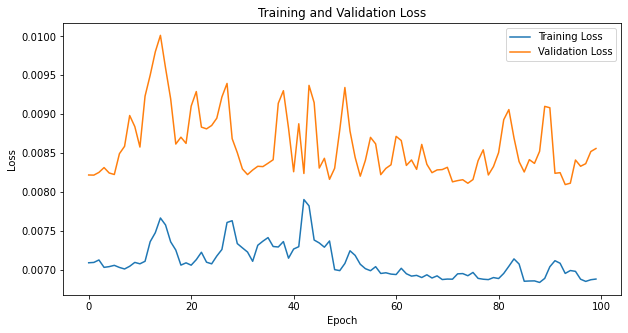

In [116]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [117]:
check_accuracy(model3.predict([data['dev_x_inn'], data['dev_x_pl']]), data['dev_y'], 10, 0, 30)

(95, 150, 1)
(95, 150, 1)


array([0.4])

In [118]:
check_accuracy(model3.predict([data['train_x_inn'], data['train_x_pl']]), data['train_y'], 10, 0, 30)

(978, 150, 1)
(978, 150, 1)


array([0.43739514])

In [121]:
output_scaler.inverse_transform(model3.predict([data['dev_x_inn'], data['dev_x_pl']])[5])

array([[166.37408],
       [167.2141 ],
       [155.67664],
       [150.07816],
       [150.45317],
       [156.9554 ],
       [160.99911],
       [154.79202],
       [155.04654],
       [154.50035],
       [157.99196],
       [159.30014],
       [159.18149],
       [158.90643],
       [157.11751],
       [156.89499],
       [155.32791],
       [155.24767],
       [156.82411],
       [156.70534],
       [157.92319],
       [160.1505 ],
       [158.16318],
       [150.13396],
       [152.89764],
       [158.90948],
       [160.52112],
       [164.50122],
       [161.79585],
       [165.6909 ],
       [166.27525],
       [169.12038],
       [167.15355],
       [170.21355],
       [169.2662 ],
       [167.28171],
       [170.8237 ],
       [171.17902],
       [171.06932],
       [169.05858],
       [168.30875],
       [167.61752],
       [167.48297],
       [168.54848],
       [167.5556 ],
       [169.24979],
       [168.69046],
       [167.84131],
       [168.55661],
       [168.95761],


In [122]:
output_scaler.inverse_transform(data['dev_y'][5])

array([[ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.99998],
       [ 157.

### Saving this model

In [123]:
model3.save(parent_dir/'Models'/'tfmodel3_2.h5')

## Model # 2